<a href="https://colab.research.google.com/github/siddas18/Natural-Disaster-Damage-Prediction/blob/Kartik/Data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt
from math import sqrt, isnan
import requests
import gzip
from functools import reduce
import scipy as scp

import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

In [3]:
def get_NOAA_data():
    
    URL = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"
    r = requests.get(URL)
    file_names = pd.read_html(r.text)[0]['Name']
    events_file_names = file_names[file_names.str.contains("details",na=False)]
    noaa_list = []
    
    print("Extracting CSV files...")
    for file in events_file_names:
        full_URL = URL + file
        with gzip.open(requests.get(full_URL, stream=True).raw) as f:
            noaa_list.append(pd.read_csv(f))
        
    df = pd.concat(noaa_list)
    
    print("Completed")
    return df

def pickle_source_data():
    noaa_source_df = get_NOAA_data()
    home_dir = os.getcwd()
    data_dir = os.path.join(home_dir, "Data")
    try:
        os.mkdir(data_dir)
        os.chdir(data_dir)
    except OSError:
        os.chdir(data_dir)
        for file in os.listdir():
            os.remove(file)
    noaa_source_df.to_pickle('noaa_source_data.pkl')
    os.chdir(home_dir)
    return noaa_source_df

NOAA_df = pickle_source_data()
    

Extracting CSV files...
Completed


In [4]:
pickle_df = pd.read_pickle('Data/noaa_source_data.pkl')

In [5]:
NOAA_df = pd.read_pickle('Data/noaa_source_data.pkl')

In [6]:
def replace_str2num(x):
    if type(x) == float or type(x) == int:
        return float(x)
    num = 1 if x[:-1] == '' else x[:-1]        
    if x[-1] == 'T':
        return float(num) * 1000000000000
    elif x[-1] == 'B':
        return float(num) * 1000000000
    elif x[-1] == 'M':
        return float(num) * 1000000
    elif x[-1] == 'K' or x[-1] == 'k':
        return float(num) * 1000
    elif x[-1] == 'h' or x[-1] == 'H':
        return float(num) * 100
    elif x[-1] == '?':
        return float(num)
    else:
        return float(x)

def winds(x):
    if x['MAGNITUDE_TYPE'] in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def hail(x):
    if x['MAGNITUDE_TYPE'] not in ['EG', 'E', 'M', 'ES', 'MG', 'MS']:
        return x['MAGNITUDE']

def missing_swap(df, col1, col2):
    df.loc[~df[col1].isnull() & df[col2].isnull(), col2] = df.loc[~df[col1].isnull() & df[col2].isnull(), col1]
    df.loc[df[col1].isnull() & ~df[col2].isnull(), col1] = df.loc[df[col1].isnull() & ~df[col2].isnull(), col2]
    return df

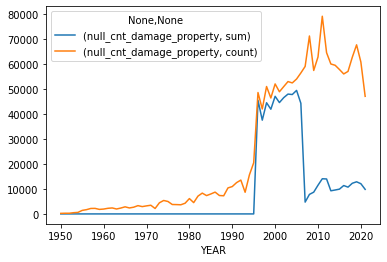

In [11]:
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_CROPS'].isnull()
df1 = NOAA_df.groupby('YEAR').agg({'null_cnt_damage_property' : ['sum', 'count']})
df1.plot()

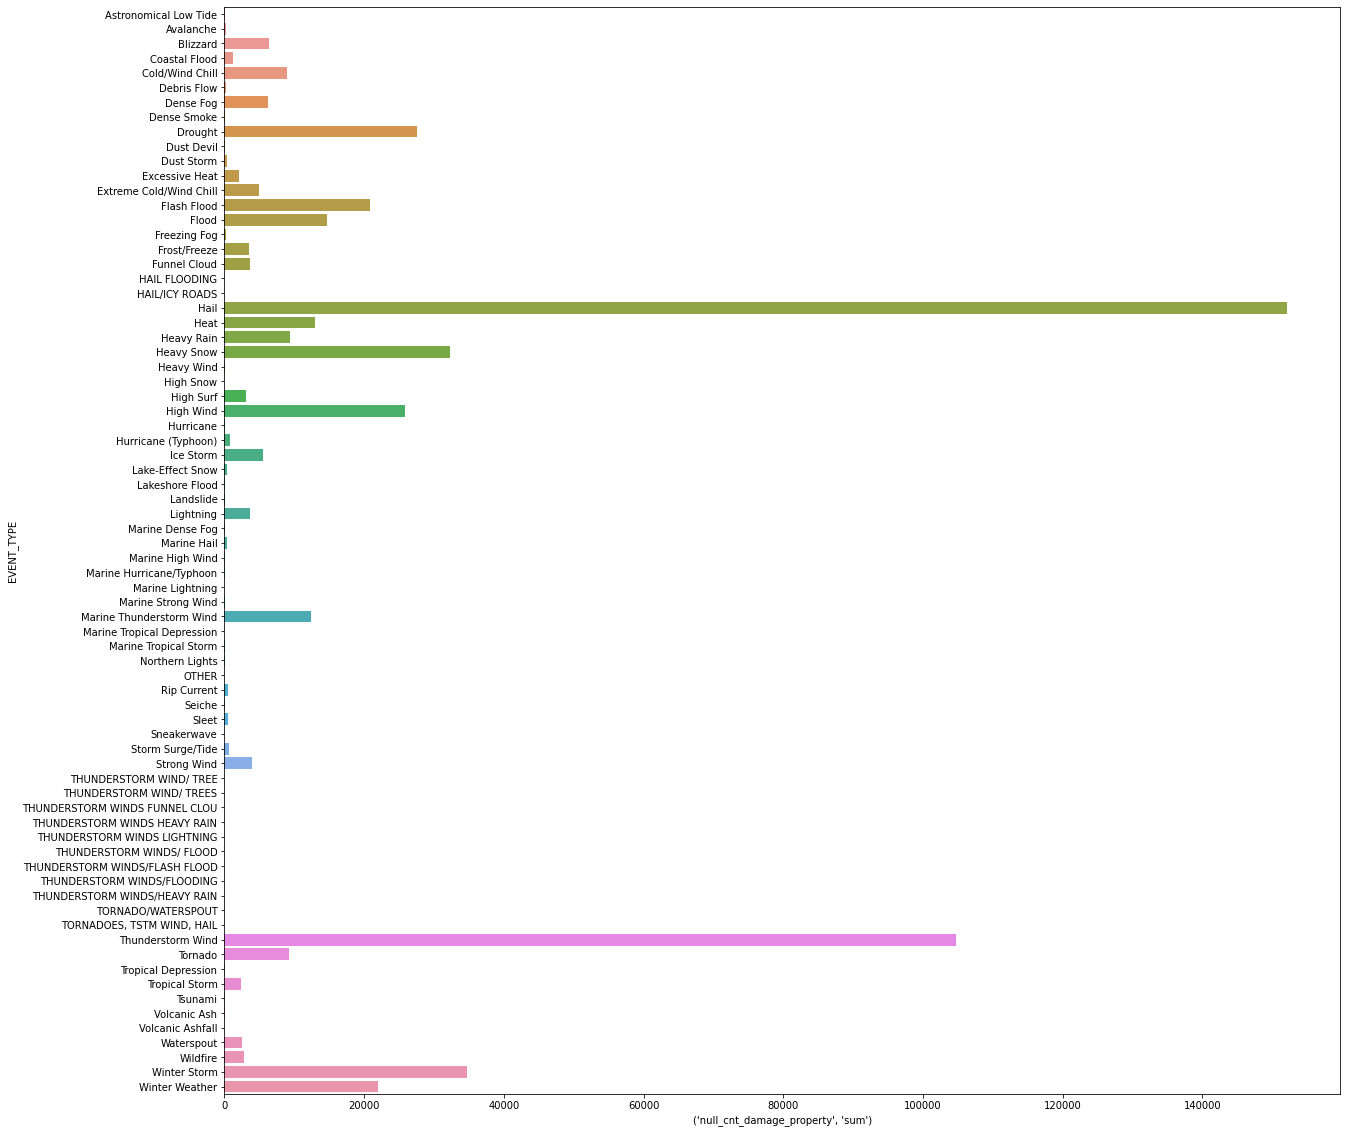

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
NOAA_df['null_cnt_damage_property'] = NOAA_df['DAMAGE_PROPERTY'].isnull()
df1 = NOAA_df.groupby('EVENT_TYPE').agg({'null_cnt_damage_property' : ['sum', 'count']}).reset_index()
df1['perc'] = df1[('null_cnt_damage_property', 'sum')] / df1[('null_cnt_damage_property', 'count')] * 100
plt.figure(figsize=(20, 20))
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df1, y='EVENT_TYPE', x=('null_cnt_damage_property', 'sum'))

plt.show()

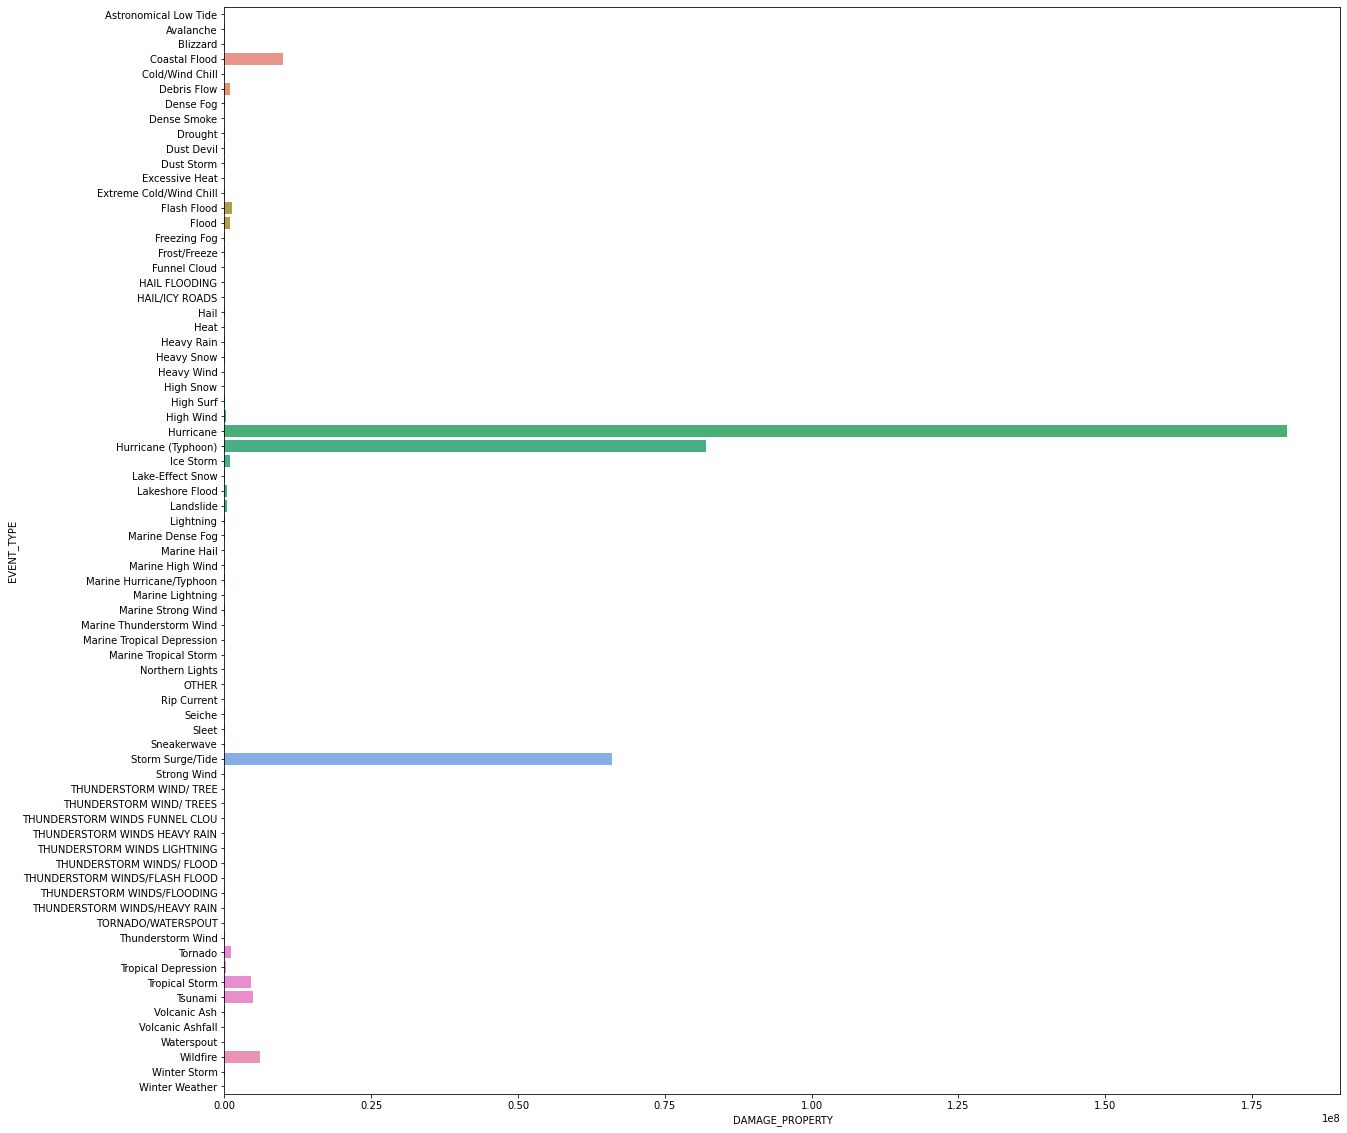

In [68]:
df2 = NOAA_df.groupby('EVENT_TYPE').mean()['DAMAGE_PROPERTY'].reset_index()
df2 = df2[df2.EVENT_TYPE != 'TORNADOES, TSTM WIND, HAIL']
plt.figure(figsize=(20, 20))
# df2.head()
# sns.barplot(data=df1, y='EVENT_TYPE', x='perc')
sns.barplot(data=df2, y='EVENT_TYPE', x='DAMAGE_PROPERTY')
plt.show()
# NOAA_df['DAMAGE_PROPERTY'] = NOAA_df.DAMAGE_PROPERTY.map(replace_str2num)

In [ ]:
def impute_NOAA_data(df):
    
    # maginitude converted into other variables
    drop_list = ['EVENT_NARRATIVE', 'EPISODE_NARRATIVE', 'EPISODE_ID', 'MAGNITUDE']
    impute_mean_list = ['BEGIN_LAT', 'END_LAT', 'BEGIN_LON', 'END_LON']
    
    # imputing damage columns with 0 for the time-being
    impute_zero_list = ['TOR_WIDTH', 'TOR_LENGTH', 'BEGIN_RANGE', 'END_RANGE', 'DAMAGE_CROPS', \
                        'DAMAGE_PROPERTY', 'WIND_SPEED', 'HAIL_SIZE']
    impute_NA_list = ['TOR_OTHER_CZ_NAME', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_WFO', 'TOR_F_SCALE', \
                      'CATEGORY', 'FLOOD_CAUSE', 'SOURCE', 'WFO', 'CZ_NAME', 'DATA_SOURCE', 'STATE', \
                      'STATE_FIPS', 'MAGNITUDE_TYPE', 'BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LOCATION', \
                      'END_LOCATION', 'TOR_OTHER_CZ_FIPS']
    
    # Removing inconsistencies
    df = missing_swap(df, 'BEGIN_RANGE', 'END_RANGE')
    df = missing_swap(df, 'BEGIN_LAT', 'END_LAT')
    df = missing_swap(df, 'BEGIN_LON', 'END_LON')
    df = missing_swap(df, 'BEGIN_AZIMUTH', 'END_AZIMUTH')
    df = missing_swap(df, 'BEGIN_LOCATION', 'END_LOCATION')
    
    # Damage variables cleaning
    df['DAMAGE_PROPERTY'] = df.DAMAGE_PROPERTY.map(replace_str2num)
    df['DAMAGE_CROPS'] = df.DAMAGE_CROPS.map(replace_str2num)
    
    # Splitting magnitude variable into constituent attributes
    df['WIND_SPEED'] = df.apply(winds, axis = 1)
    df['HAIL_SIZE'] = df.apply(hail, axis = 1)
    
    # Imputing string columns with missing values with N/A
    for col in impute_NA_list:
        df[col] = df[col].astype('str').apply(lambda x: 'N/A' if x=='nan' else x)
        
    # Imputing float columns having missing values with 0.0
    for col in impute_zero_list:
        df[col] = df[col].fillna(0.0)
        
    # Imputing latitude and longitudes with average value
    for col in impute_mean_list:
        df[col] = df[col].fillna(np.mean)
        
    # Dropping text and ID columns
    for col in drop_list:
        df.drop(col, axis=1, inplace=True)
    
    return df

imputed_NOAA_df = impute_NOAA_data(NOAA_df.copy())
imputed_NOAA_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EVENT_ID,STATE,STATE_FIPS,YEAR,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,DATA_SOURCE,WIND_SPEED,HAIL_SIZE
0,195004,28,1445,195004,28,1445,10096222,OKLAHOMA,40.0,1950,...,0.0,N/A,N/A,35.12,-99.2,35.17,-99.2,PUB,0.0,0.0
1,195004,29,1530,195004,29,1530,10120412,TEXAS,48.0,1950,...,0.0,N/A,N/A,31.9,-98.6,31.73,-98.6,PUB,0.0,0.0
2,195007,5,1800,195007,5,1800,10104927,PENNSYLVANIA,42.0,1950,...,0.0,N/A,N/A,40.58,-75.7,40.65,-75.47,PUB,0.0,0.0
3,195007,5,1830,195007,5,1830,10104928,PENNSYLVANIA,42.0,1950,...,0.0,N/A,N/A,40.6,-76.75,40.6,-76.75,PUB,0.0,0.0
4,195007,24,1440,195007,24,1440,10104929,PENNSYLVANIA,42.0,1950,...,0.0,N/A,N/A,41.63,-79.68,41.63,-79.68,PUB,0.0,0.0


In [ ]:
def get_EPA_data():
    
    ground_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/temperature_fig-1.csv', skiprows=6, usecols = [0, 1], encoding='latin1')
    ground_temp_df.columns = ["YEAR", "SURFACE_TEMP_DIFF"]
    
    greenhouse_df = pd.read_csv("https://www.epa.gov/sites/default/files/2021-04/us-ghg-emissions_fig-1.csv",skiprows=6)
    greenhouse_df.columns = ["YEAR", "CO2", "METHANE", "N2O", "HFC, PFC, SF6, NF3"]
    
    precipitation_df =  pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/heavy-precip_fig-1.csv',skiprows=6)
    precipitation_df.columns = ["YEAR", "PPT_LAND_AREA", "PPT_NINE_YEAR_AVG"]
    
    sea_level_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/sea-level_fig-1.csv', skiprows=6)
    sea_level_df.columns = ["YEAR", "CSIRO_ADJ_SEA_LEVEL", "CSIRO_LOWER", "CSIRO_UPPER", "NOAA_ADJ_SEA_LEVEL"]
    sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'CSIRO_ADJ_SEA_LEVEL'] = sea_level_df.loc[sea_level_df['YEAR'] > 1992, 'NOAA_ADJ_SEA_LEVEL']
    sea_level_df.drop(['CSIRO_LOWER', 'CSIRO_UPPER', 'NOAA_ADJ_SEA_LEVEL'], axis=1, inplace=True)
    
    seasonal_temp_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-04/seasonal-temperature_fig-1.csv', skiprows=6)
    seasonal_temp_df.columns = ["YEAR", "WINTER_ANOMALY", "SPRING_ANOMALY", "SUMMER_ANOMALY", "FALL_ANOMALY"]
    
    arctic_ice_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/arctic-sea-ice_fig-1.csv', skiprows=6)
    arctic_ice_df.columns = ["YEAR", "ICE_CVG_MARCH", "ICE_CVG_SEP"]
    
    glacier_df = pd.read_csv('https://www.epa.gov/sites/default/files/2021-03/glaciers_fig-1.csv', skiprows=6)
    glacier_df.columns = ["YEAR", "GLACIER_MASS_BAL", "NUM_OBS"]
    glacier_df.drop(['NUM_OBS'], axis=1, inplace=True)
    
    dfs = [ground_temp_df, greenhouse_df, precipitation_df, sea_level_df, seasonal_temp_df, arctic_ice_df, glacier_df]
    epa_df = reduce(lambda left, right: pd.merge(left, right, how="outer", on="YEAR"), dfs)
    epa_df = epa_df[epa_df.YEAR >= 1950]
    
    return epa_df

epa_source_df = get_EPA_data()

In [ ]:
def impute_EPA_DATA(df, breaks):
    fillable_cols = df.columns[df.isnull().sum() > 0]
    for col in fillable_cols:
        temp_df = df[['YEAR', col]]
        present_df = temp_df[~ temp_df[col].isnull()]
        null_df = temp_df[temp_df[col].isnull()]
        years = sorted(np.random.choice(present_df['YEAR'], breaks))
        input_df = present_df[present_df['YEAR'].isin(years)]
        func = scp.interpolate.interp1d(input_df['YEAR'], input_df[col], fill_value="extrapolate")
        temp_df['INTERPOLATION'] = func(temp_df['YEAR'])
        df[col] = temp_df.apply(lambda x: x['INTERPOLATION'] if isnan(x[col]) else x[col], axis=1)
    return df
        
imputed_EPA_df = impute_EPA_DATA(epa_source_df.copy(), 6)
imputed_EPA_df.head()

,YEAR,SURFACE_TEMP_DIFF,CO2,METHANE,N2O,"HFC, PFC, SF6, NF3",PPT_LAND_AREA,PPT_NINE_YEAR_AVG,CSIRO_ADJ_SEA_LEVEL,WINTER_ANOMALY,SPRING_ANOMALY,SUMMER_ANOMALY,FALL_ANOMALY,ICE_CVG_MARCH,ICE_CVG_SEP,GLACIER_MASS_BAL
49,1950,-0.63,702.184832,847.599809,281.857201,-97.772042,0.100,0.085488,3.598425,0.85,-1.94,-1.68,0.32,7.072426,2.654838,3.116000
50,1951,-0.90,808.351302,844.625591,285.793109,-93.175619,0.107,0.093453,3.972441,0.35,-1.24,-0.66,-1.49,7.046364,2.657155,2.788667
51,1952,0.25,914.517772,841.651374,289.729018,-88.579195,0.077,0.099285,3.870079,0.67,-0.94,1.16,-0.63,7.020303,2.659472,2.461333
52,1953,1.35,1020.684243,838.677156,293.664926,-83.982772,0.123,0.102855,4.043307,3.02,-0.36,0.75,1.87,6.994241,2.661788,2.134000
53,1954,1.31,1126.850713,835.702938,297.600834,-79.386348,0.099,0.101262,3.929134,3.10,-0.25,0.77,1.51,6.968179,2.664105,1.806667


In [ ]:
cleaned_df = pd.merge(imputed_NOAA_df, imputed_EPA_df, on='YEAR', how='inner')
cleaned_df.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EVENT_ID,STATE,STATE_FIPS,YEAR,...,PPT_LAND_AREA,PPT_NINE_YEAR_AVG,CSIRO_ADJ_SEA_LEVEL,WINTER_ANOMALY,SPRING_ANOMALY,SUMMER_ANOMALY,FALL_ANOMALY,ICE_CVG_MARCH,ICE_CVG_SEP,GLACIER_MASS_BAL
0,195004,28,1445,195004,28,1445,10096222,OKLAHOMA,40.0,1950,...,0.1,0.085488,3.598425,0.85,-1.94,-1.68,0.32,7.072426,2.654838,3.116
1,195004,29,1530,195004,29,1530,10120412,TEXAS,48.0,1950,...,0.1,0.085488,3.598425,0.85,-1.94,-1.68,0.32,7.072426,2.654838,3.116
2,195007,5,1800,195007,5,1800,10104927,PENNSYLVANIA,42.0,1950,...,0.1,0.085488,3.598425,0.85,-1.94,-1.68,0.32,7.072426,2.654838,3.116
3,195007,5,1830,195007,5,1830,10104928,PENNSYLVANIA,42.0,1950,...,0.1,0.085488,3.598425,0.85,-1.94,-1.68,0.32,7.072426,2.654838,3.116
4,195007,24,1440,195007,24,1440,10104929,PENNSYLVANIA,42.0,1950,...,0.1,0.085488,3.598425,0.85,-1.94,-1.68,0.32,7.072426,2.654838,3.116
